## Charge the libraries

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import standard libraries
import os
import sys

# Import third-party libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            roc_curve,
                            roc_auc_score,
                            classification_report
                        )
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

## Functions to use in the code

In [3]:
def visualize_distribution(dataframe, columns):
    """
    Creates distribution visualizations for the specified columns.
    For each column, generates a 1x2 plot with histogram and boxplot.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - columns: List of column names to visualize
    """
    # Configure seaborn style
    sns.set(style="whitegrid")
    
    # Iterate over each column and create its visualizations
    for column in columns:
        # Create figure with two subplots (1 rows, 2 column)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Main title for the complete figure
        fig.suptitle(f'Distribution Analysis: {column}', fontsize=16)
        
        # Subplot 1: Histogram with density estimator
        sns.histplot(dataframe[column], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')
        
        # Subplot 2: Boxplot
        sns.boxplot(x=dataframe[column], ax=axes[1])
        axes[1].set_title(f'Boxplot of {column}')
        axes[1].set_xlabel(column)

        # Adjust layout and display
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Leave space for the main title
        plt.show()

In [4]:
def visualize_features_by_class(dataframe, features_list, target_name):
    """
    Visualize the distribution of features by class (target variable values).
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - features_list: List of feature column names to visualize
    - target_name: Name of the target variable column
    """
    # Check if the dataframe is valid
    if dataframe is None or dataframe.empty:
        print("Cannot visualize: DataFrame is empty or None")
        return
    
    # Check if the target column exists
    if target_name not in dataframe.columns:
        print(f"Target column '{target_name}' not found in the dataframe")
        return
    
    # Get unique values in the target column
    target_values = dataframe[target_name].unique()
    
    # For each feature, create a plot showing distribution by class
    for i, feature in enumerate(features_list):
        # Check if the feature column exists
        if feature not in dataframe.columns:
            print(f"Feature column '{feature}' not found in the dataframe")
            continue
        
        # Create figure with fixed size
        plt.figure(figsize=(12, 5))
        
        # Plot histogram for each class
        for target_val, label in zip(target_values, ['No Default', 'Default']):
            # Subset the dataframe to include only rows with this class
            subset = dataframe[dataframe[target_name] == target_val]
            
            # Plot histogram of this feature for this class
            plt.hist(subset[feature], alpha=0.5, label=label, bins=30)
        
        # Add title and labels
        plt.title(f'{feature.capitalize()} Distribution by Class')
        plt.xlabel(feature.capitalize())
        plt.ylabel('Frequency')
        plt.legend()
        
        # Display the plot
        plt.tight_layout()
        plt.show()

In [5]:
def plot_correlation_with_target(dataframe, features_list, target_name, figsize=(12, 8)):
    """
    Creates a correlation heatmap showing relationships between selected features and a target variable.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - features_list: List of feature column names to include in the correlation analysis
    - target_name: Name of the target variable column
    - figsize: Tuple specifying the figure size (width, height)
    """
    # Ensure target is included in the features to correlate
    columns_to_correlate = features_list.copy()
    if target_name not in columns_to_correlate:
        columns_to_correlate.append(target_name)
    
    # Select only the specified columns from the dataframe
    selected_df = dataframe[columns_to_correlate]
    
    # Calculate the correlation matrix
    correlation_matrix = selected_df.corr()
    
    # Create the figure
    plt.figure(figsize=figsize)
    
    # Generate the heatmap
    sns.heatmap(
        correlation_matrix, 
        annot=True,               # Show correlation values inside cells
        fmt=".2f",                # Format to 2 decimal places
        cmap='coolwarm',          # Color map (red = negative, blue = positive)
        square=True,              # Make cells square-shaped
        cbar_kws={"shrink": .8},  # Customize the color bar
        vmin=-1, vmax=1           # Set the min/max of the color scale to -1/1
    )
    
    # Add title and adjust layout
    plt.title(f'Correlation Matrix with Target: {target_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
def result_metrics(cm):
    """
    Calculate sensitivity, specificity and accuracy from a confusion matrix.
    
    Parameters:
    - cm: array-like of shape (2, 2)
            Confusion matrix with format:
            [[TN, FP],
            [FN, TP]]
    
    Returns:
    - sensitivity: Also known as recall or true positive rate (float)
    - specificity: Also known as true negative rate (float)
    - accuracy: Overall accuracy of the model (float)
    """
    # Extract the true negatives, false positives, false negatives, and true positives
    # from the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate the metrics
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    precision = tp / (tp + fp)    # Positive Predictive Value
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) # F1 Score
    accuracy = (tp + tn) / (tp + tn + fp + fn) # Overall accuracy

    # Return the calculated metrics
    return sensitivity, specificity, precision, f1_score, accuracy

In [7]:
def plot_roc_curve(y_test, y_prob, model_name="Model", figsize=(8, 6)):
    """
    Plot ROC curve for a single classification model.
    
    Parameters:
    - y_test: True target values for the test set (array-like)
    - y_prob: Prediction probabilities for the positive class (array-like)
    - model_name: Name of the model to display in the plot (str, optional)
    - figsize: Figure size (width, height) in inches (tuple, optional)
    
    Returns:
    - auc_score: Area Under the ROC Curve score (float)
    """
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})", linewidth=2)
    
    # Add diagonal line representing random chance
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    
    # Add labels and title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Set axes limits
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    return auc_score

In [8]:
def plot_confusion_matrix(y_test, y_pred, model_name="Model", figsize=(6, 5)):
    """
    Plot confusion matrix for a classification model and return the confusion matrix.
    
    Parameters:
    - y_test: True target values for the test set (array-like)
    - y_pred: Predicted class labels (array-like)
    - model_name: Name of the model to display in the plot (str, optional)
    - figsize: Figure size (width, height) in inches (tuple, optional)
    
    Returns:
    - cm: Confusion matrix [[TN, FP], [FN, TP]] (array, shape (2, 2))
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot confusion matrix as heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    
    # Add colorbar
    plt.colorbar()
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    # Set labels and ticks
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
    plt.yticks([0, 1], ['Negative (0)', 'Positive (1)'])
    
    plt.tight_layout()
    plt.show()
    
    return cm

In [9]:
def remove_outliers(dataframe, column):
    """
    Removes outliers from the specified column in the DataFrame using IQR method.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data
    - column: Name of the column to check for outliers
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to remove outliers
    filtered_df = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    
    return filtered_df

## Charge the dataset

In [10]:
# Attempt to load the Default dataset
default_data_available = False
default_df = None

# Try to loading from the local file
try:
    print("Loading Default dataset from local file")

    # Path to the Default dataset
    default_path = os.path.join(os.getcwd(), "datasets", "Default.csv")

    # Read the dataset from the specified path
    raw_df = pd.read_csv(default_path, sep=",", index_col=0)

    # Define features names based on predictor variables
    features = ['balance', 'income']
    target = 'default'

    # Create Pandas dataframe
    default_df = pd.DataFrame(raw_df, columns=features)
    default_df[target] = raw_df[target]

    # Reset the index
    default_df.reset_index(drop=True, inplace=True)

    # Set the flag to indicate successful loading
    default_data_available = True
    print("Default dataset loaded successfully.")

except Exception as e:
    print(f"Error loading Default dataset: {e}")
    print("Cannot proceed without the dataset. Please check the local file path.")
    print("Note: The Default dataset hasn't been provided in the repository.")

Loading Default dataset from local file
Default dataset loaded successfully.


## Explore the data Structure

In [11]:
# Analyze the data only if was loaded successfully
try:
    if default_data_available and default_df is not None:

        # Explore Data Structure
        print("Data Exploration")
        print("===================================")
        print("First 5 rows of the dataset:")
        print(default_df.head(), "\n")

        # Provide information of the DataFrame
        print("Dataset information (columns, data types, non-null counts):")
        print("===================================")
        default_df.info()
        print("\n")

        # Describe the statistical details (mean, std dev, min, max, quartiles) of the dataset
        print("Statistics for numerical columns:")
        print("===================================")
        print(default_df.describe(), "\n")

        # Show the distribution of the categorical columns
        print("Distribution of default values (0: No default, 1: Default):")
        print("===================================")
        print(default_df['default'].value_counts())
        print("\n")

        # Check for missing values and counts missing values per column
        print("Check for any missing values:")
        print("===================================")
        print(default_df.isnull().sum()) # Counts missing values per column, this check strategy is a good practice.
        print("\n")

    else:
        print("Analysis could not be performed as the Default dataset failed to load.")

except Exception as e:
    print(f"Error during analysis: {e}")
    print("Please check the dataset and try again.")

Data Exploration
First 5 rows of the dataset:
       balance        income default
0   729.526495  44361.625074      No
1   817.180407  12106.134700      No
2  1073.549164  31767.138947      No
3   529.250605  35704.493935      No
4   785.655883  38463.495879      No 

Dataset information (columns, data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   balance  10000 non-null  float64
 1   income   10000 non-null  float64
 2   default  10000 non-null  object 
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


Statistics for numerical columns:
            balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     265

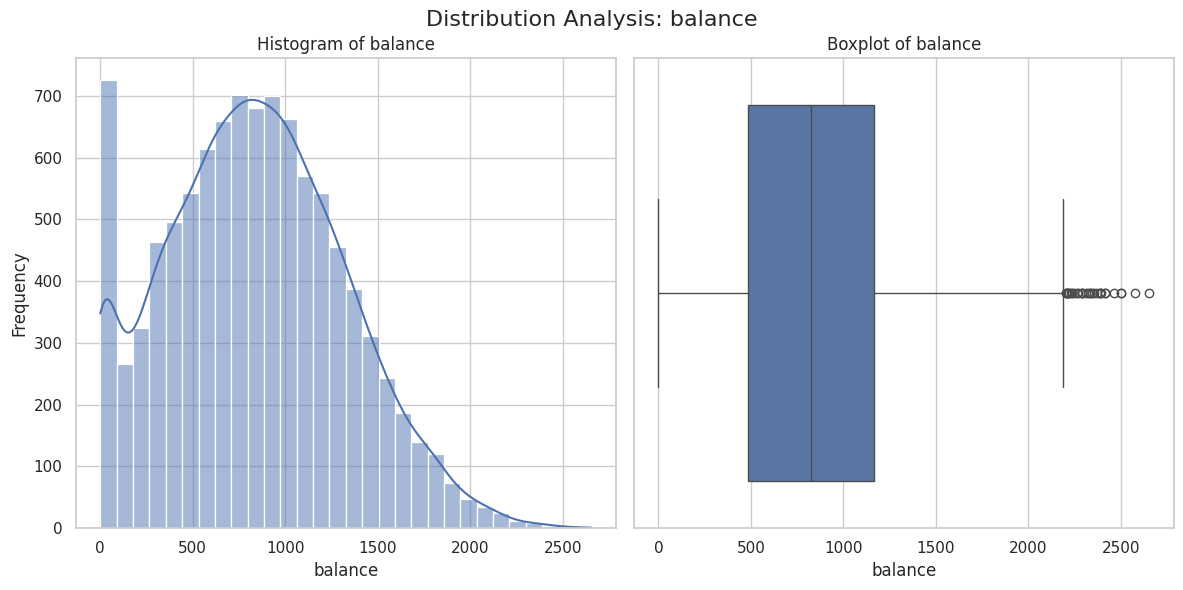

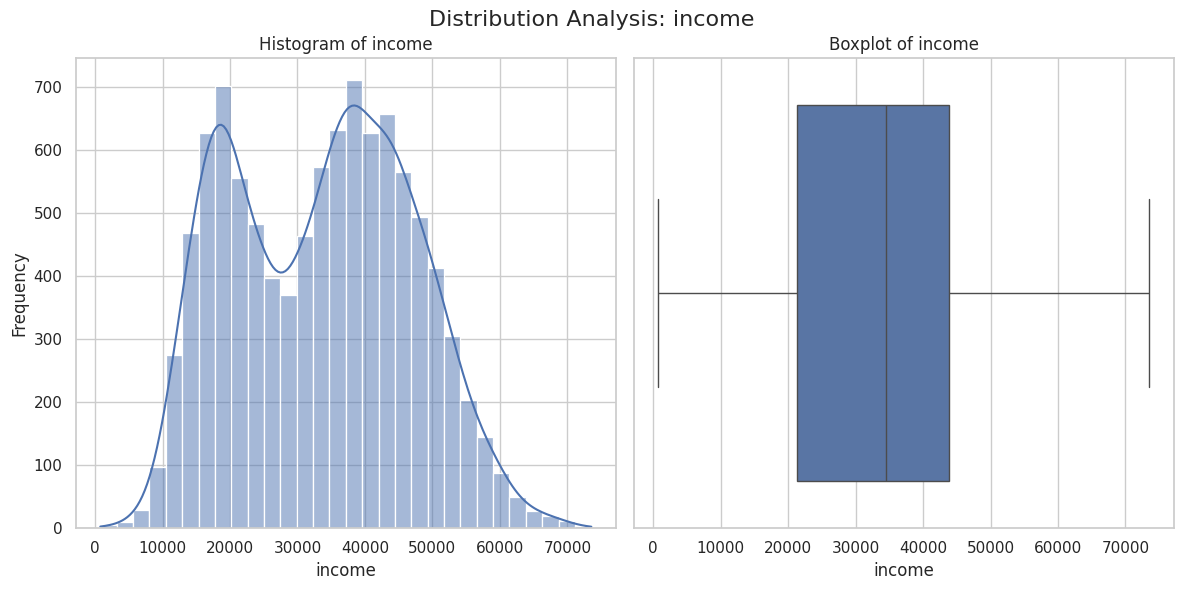

In [12]:
# Visualize the main variables used in the analysis
columns_to_visualize = ['balance', 'income']
visualize_distribution(default_df, columns_to_visualize)

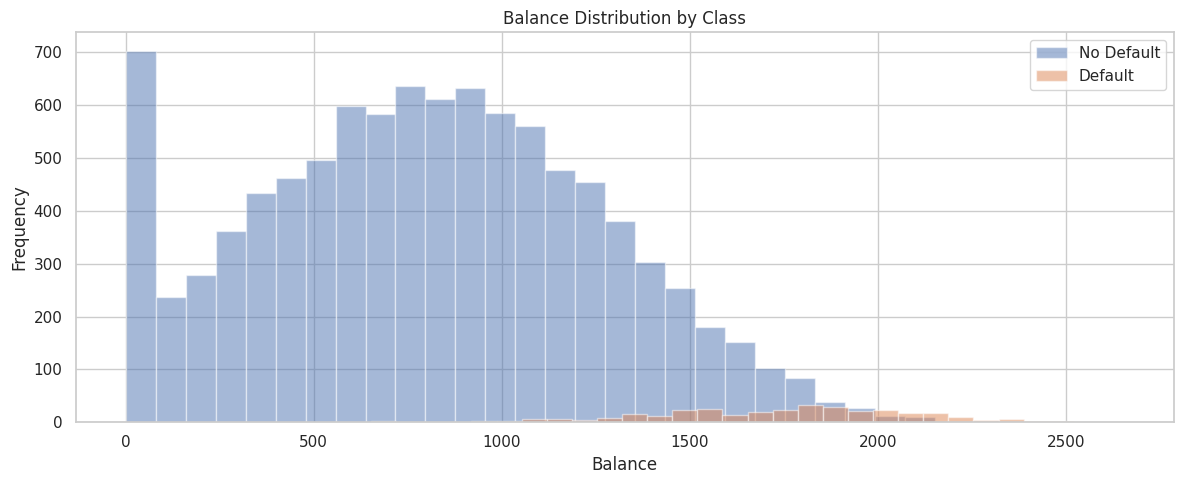

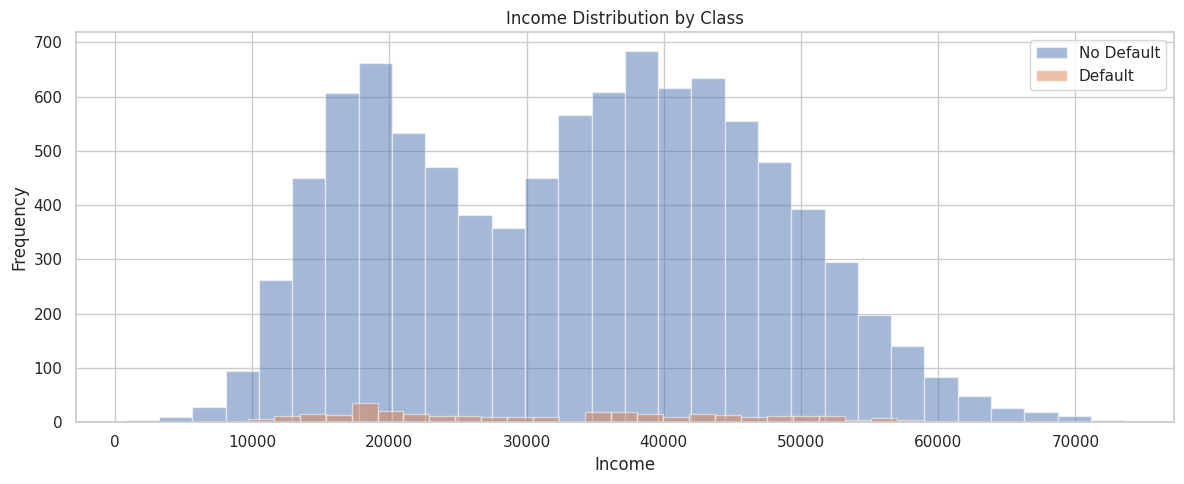

In [13]:
# Visualize the feature and its relate class
features_list = ['balance', 'income']
target_name = 'default'
visualize_features_by_class(default_df, features_list, target_name)

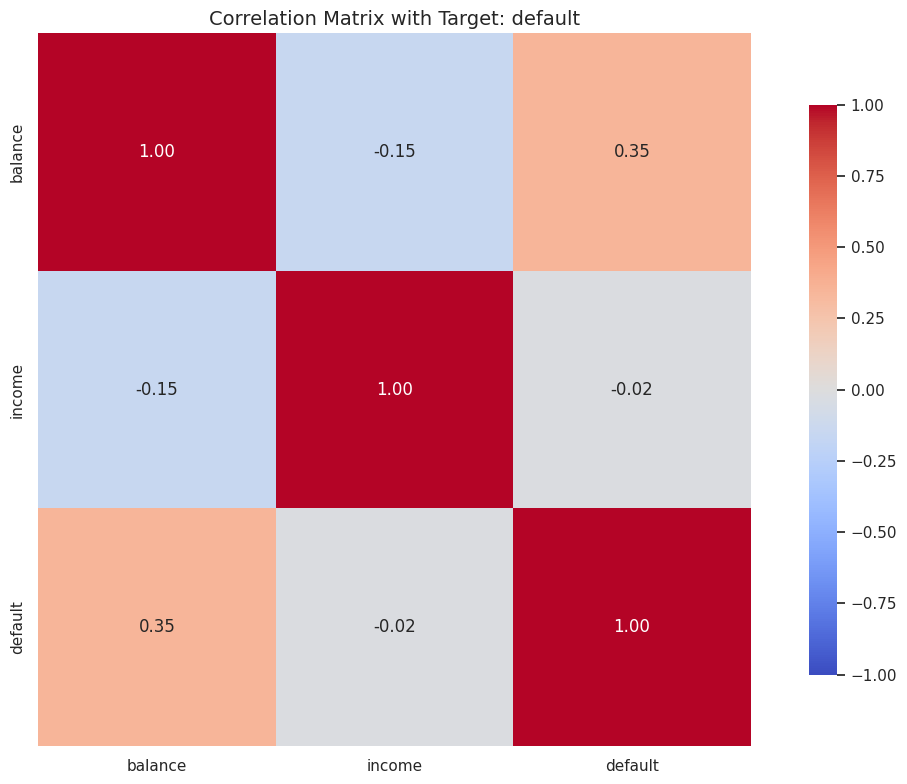

In [14]:
# Transform 'default' column to numeric values
default_df_cm = default_df.copy()
default_df_cm['default'] = default_df_cm['default'].map({'No': 0, 'Yes': 1})

# Plot correlation heatmap for selected features with the target variable
features_of_interest = ['balance', 'income']
target_name = 'default'
plot_correlation_with_target(default_df_cm, features_of_interest, target_name)

## Preprcess the dataset

In [15]:
# Transform categorical variables to numerical values ('default') to 0 and 1
default_df['default'] = default_df['default'].map({'No': 0, 'Yes': 1})

# Split the dataset into features and target variable
X = default_df.drop(columns=['default'])
y = default_df['default']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

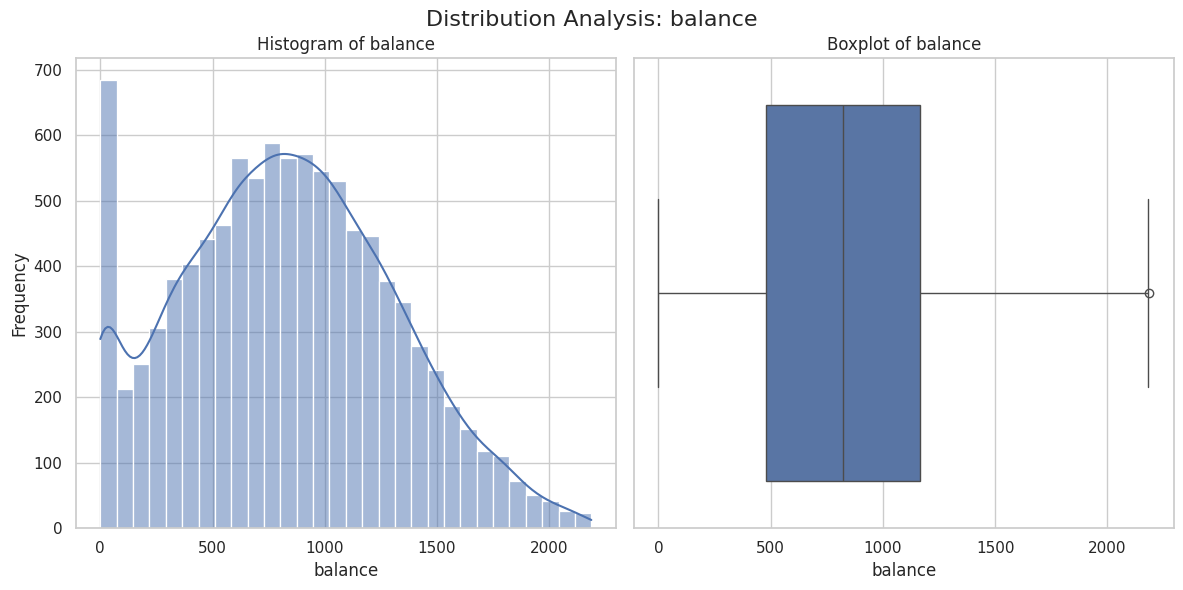

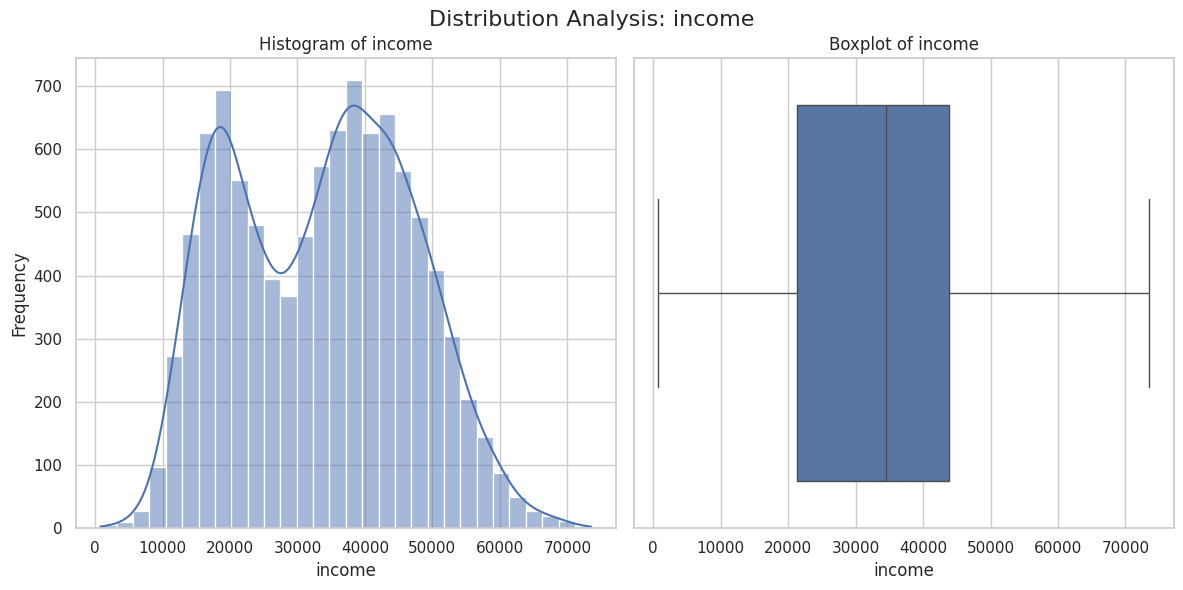

In [16]:
# Remove outliers from the 'balance' and 'income' columns
default_df_cleaned = default_df.copy()
default_df_cleaned = remove_outliers(default_df_cleaned, 'balance')
default_df_cleaned = remove_outliers(default_df_cleaned, 'income')

# Visualize the cleaned data distribution
visualize_distribution(default_df_cleaned, columns_to_visualize)

# Split the cleaned dataset into features and target variable
X_cleaned = default_df_cleaned.drop(columns=['default'])
y_cleaned = default_df_cleaned['default']

# Split the cleaned dataset into training and testing sets
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [17]:
# Scale the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

# Define the target variable
y_train_scaled = y_train_cleaned
y_test_scaled = y_test_cleaned

# Define the features and target variable
feature_name = ['balance', 'income']
target_name = 'default'

# Convert the scaled data back to DataFrame
default_df_scaled = pd.DataFrame(X_train_scaled, columns=feature_name)

# Add the target variable to the DataFrame
default_df_scaled[target_name] = y_train_scaled.values

# Display the first 5 rows of the scaled DataFrame
default_df_scaled.head()

,balance,income,default
0,-1.614177,0.159450,0
1,-0.660254,1.254315,0
2,1.216202,2.156572,0
3,-1.146409,0.477617,0
4,1.029625,-0.993645,0


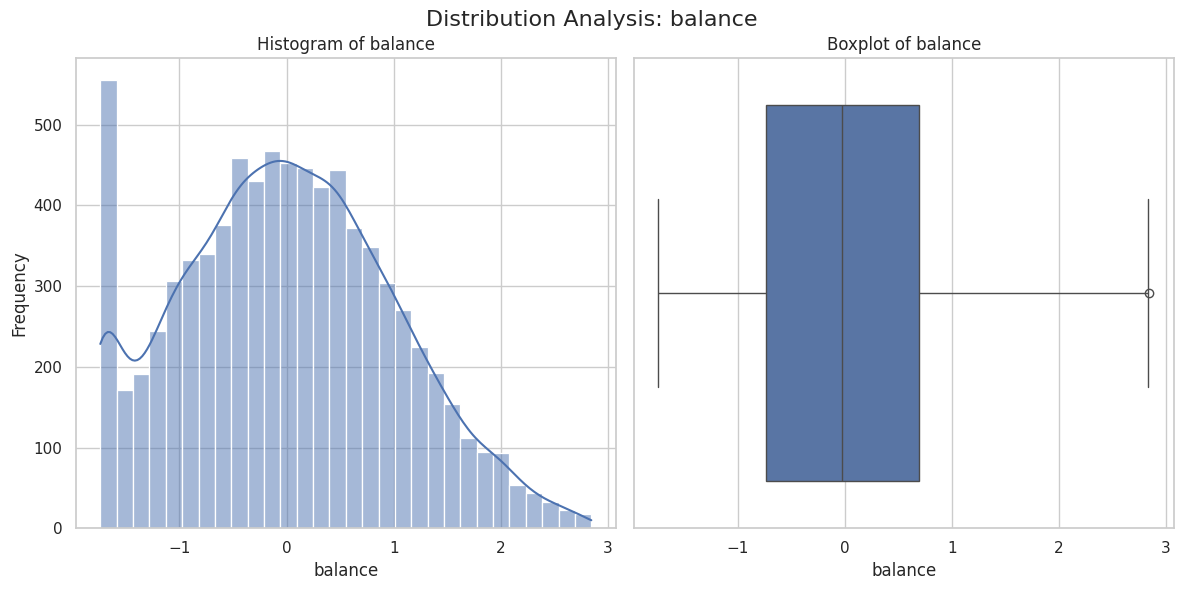

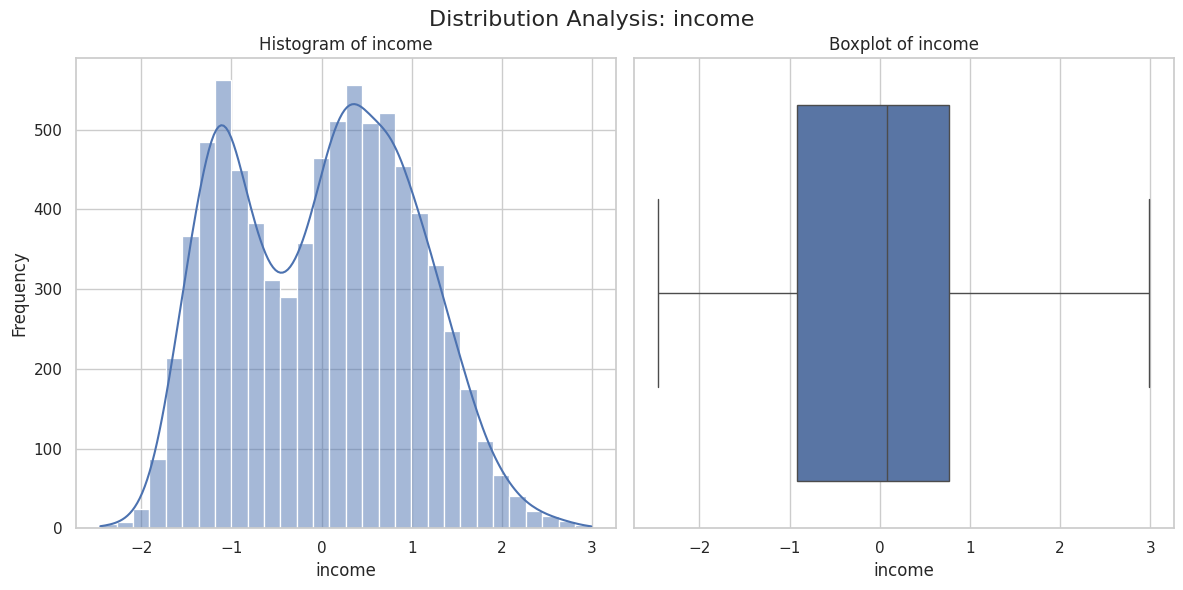

In [18]:
# Visualize the cleaned data distribution
feature_name = ['balance', 'income']
visualize_distribution(default_df_scaled, feature_name)

In [19]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)

# Resample the scaled dataset to balance the classes
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_scaled)

# Display the shape of the balanced dataset
print("Shape of the balanced dataset:")
print("===================================")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"y_train_balanced: {y_train_balanced.shape}")

# Convert the balanced data back to DataFrame
default_df_balanced = pd.DataFrame(X_train_balanced, columns=feature_name)

# Add the target variable to the DataFrame  
default_df_balanced[target_name] = y_train_balanced.values

# Display the first 5 rows of the balanced DataFrame
default_df_balanced.head()

Shape of the balanced dataset:
X_train_balanced: (15436, 2)
y_train_balanced: (15436,)


,balance,income,default
0,-1.614177,0.159450,0
1,-0.660254,1.254315,0
2,1.216202,2.156572,0
3,-1.146409,0.477617,0
4,1.029625,-0.993645,0


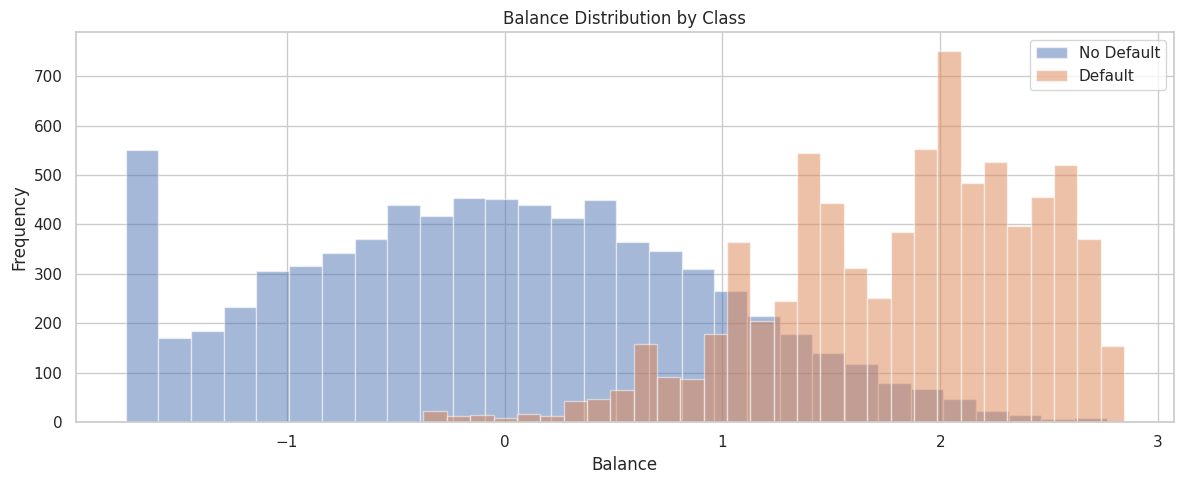

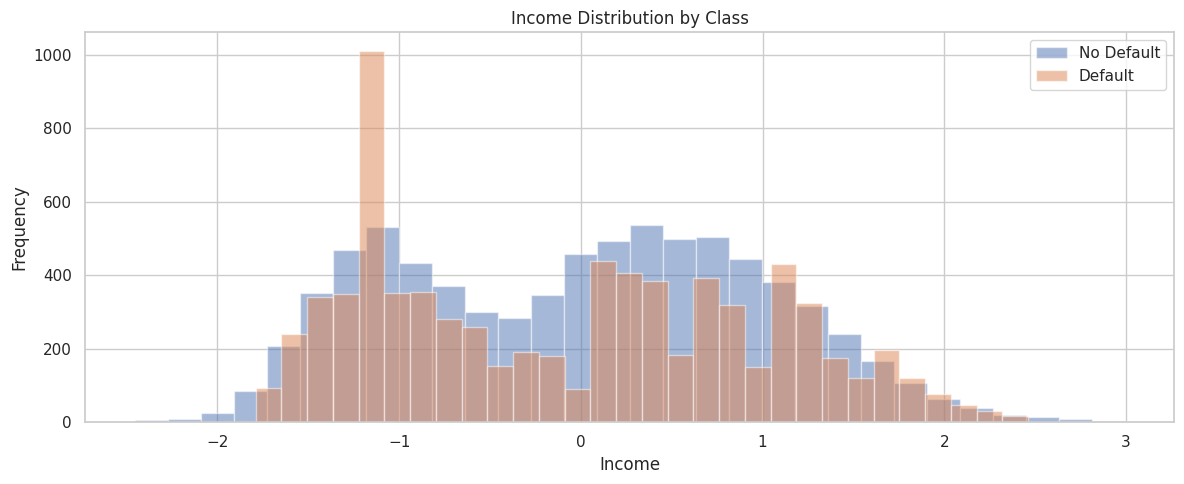

In [20]:
# Visualize the feature and its relate class
features_list = ['balance', 'income']
target_name = 'default'
visualize_features_by_class(default_df_balanced, features_list, target_name)

## Fit and test the models

### Logistic Regression

In [21]:
# Fit the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

# Fit the Logistic Regression model with cleaned data
log_reg_cleaned = LogisticRegression()
log_reg_cleaned.fit(X_train_cleaned, y_train_cleaned)
y_pred_log_cleaned = log_reg_cleaned.predict(X_test_cleaned)
y_prob_log_cleaned = log_reg_cleaned.predict_proba(X_test_cleaned)[:, 1]

# Fit the Logistic Regression model with scaled data
log_reg_scaled = LogisticRegression()
log_reg_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_log_scaled = log_reg_scaled.predict(X_test_scaled)
y_prob_log_scaled = log_reg_scaled.predict_proba(X_test_scaled)[:, 1]

# Fit the Logistic Regression model with balanced data
log_reg_balanced = LogisticRegression()
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_log_balanced = log_reg_balanced.predict(X_test_scaled)
y_prob_log_balanced = log_reg_balanced.predict_proba(X_test_scaled)[:, 1]

Logistic Regression Results
Confusion Matrix:


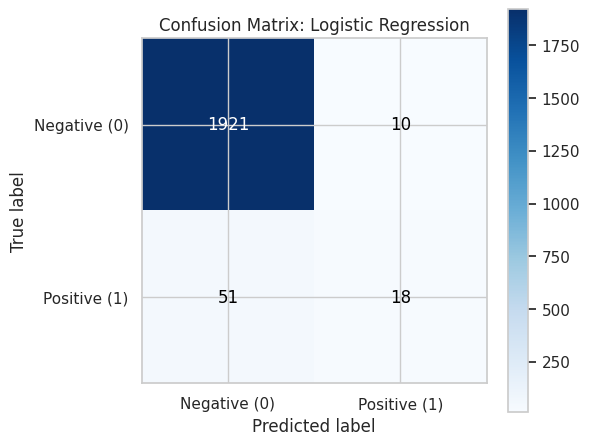

Sensitivity: 0.26
Specificity: 0.99
Precision: 0.64
F1 Score: 0.37
Accuracy: 0.97




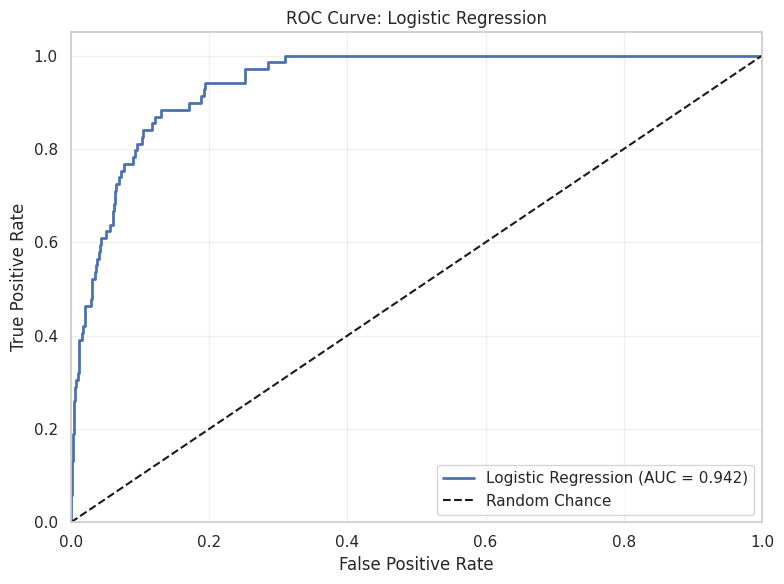

AUC: 0.94


Logistic Regression (Cleaned Data) Results
Confusion Matrix:


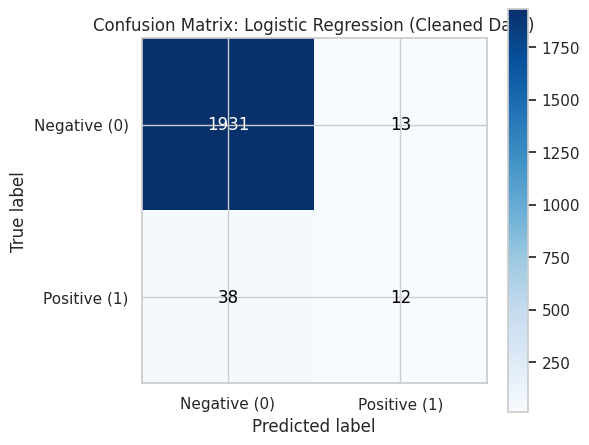

Sensitivity: 0.24
Specificity: 0.99
Precision: 0.48
F1 Score: 0.32
Accuracy: 0.97




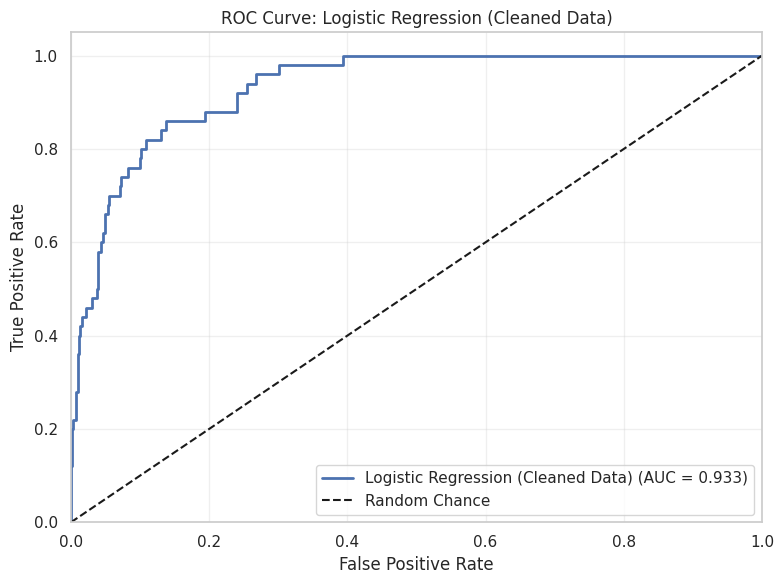

AUC: 0.93


Logistic Regression (Scaled Data) Results
Confusion Matrix:


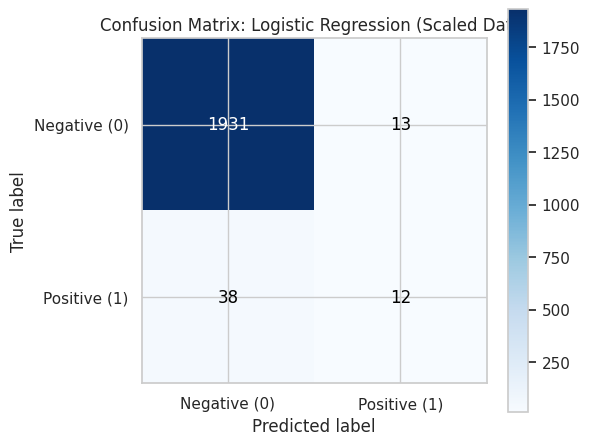

Sensitivity: 0.24
Specificity: 0.99
Precision: 0.48
F1 Score: 0.32
Accuracy: 0.97




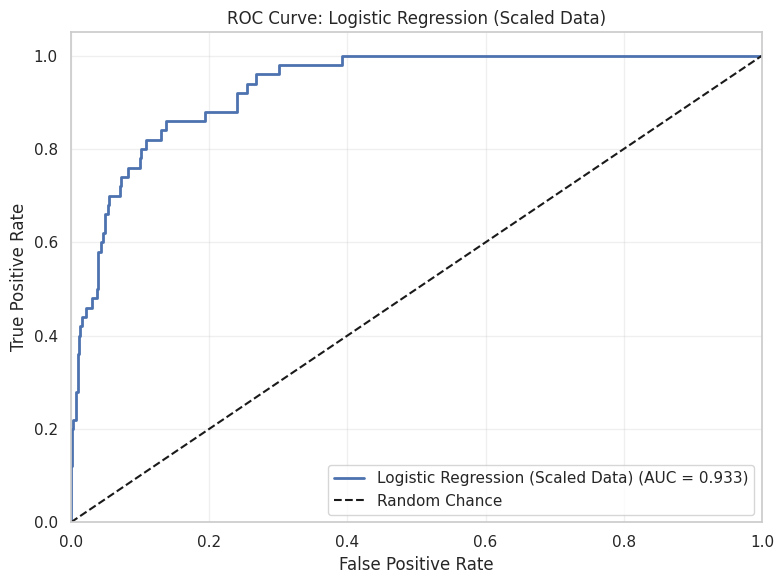

AUC: 0.93


Logistic Regression (Balanced Data) Results
Confusion Matrix:


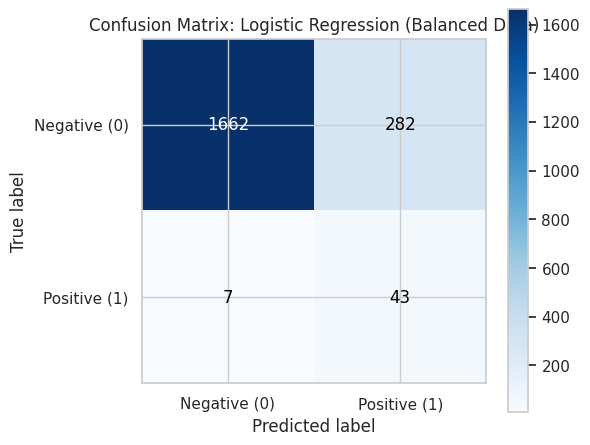

Sensitivity: 0.86
Specificity: 0.85
Precision: 0.13
F1 Score: 0.23
Accuracy: 0.86




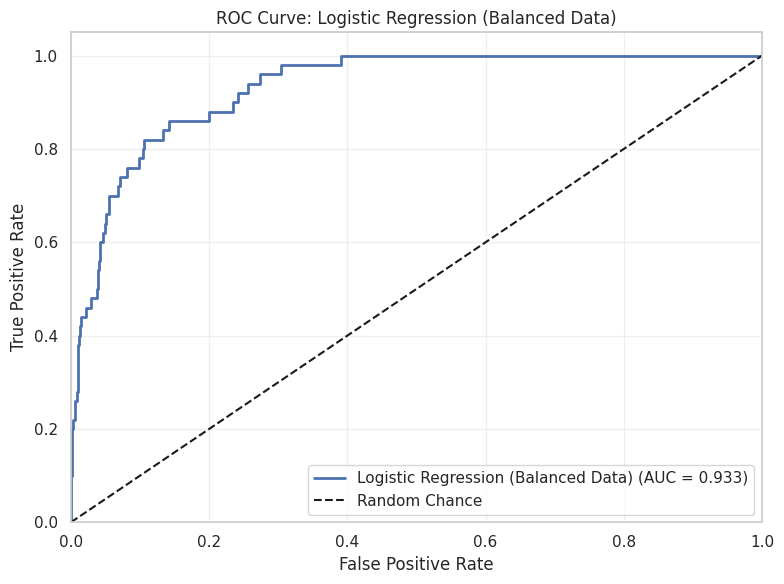

AUC: 0.93




In [22]:
# Plot and calculate metrics for Logistic Regression
if default_data_available:
    # Results for Logistic Regression
    print("Logistic Regression Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_log = plot_confusion_matrix(y_test, y_pred_log, model_name="Logistic Regression")
    sensitivity_log, specificity_log, precision_log, f1_score_log, accuracy_log = result_metrics(cm_log)
    print(f"Sensitivity: {sensitivity_log:.2f}")
    print(f"Specificity: {specificity_log:.2f}")
    print(f"Precision: {precision_log:.2f}")
    print(f"F1 Score: {f1_score_log:.2f}")
    print(f"Accuracy: {accuracy_log:.2f}")
    print("\n")
    # Plot ROC curve for Logistic Regression
    auc_log = plot_roc_curve(y_test, y_prob_log, model_name="Logistic Regression")
    print(f"AUC: {auc_log:.2f}")
    print("\n")

    
    # Results for Logistic Regression with cleaned data
    print("Logistic Regression (Cleaned Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_log_cleaned = plot_confusion_matrix(y_test_cleaned, y_pred_log_cleaned, model_name="Logistic Regression (Cleaned Data)")
    sensitivity_log_cleaned, specificity_log_cleaned, precision_log_cleaned, f1_score_log_cleaned, accuracy_log_cleaned = result_metrics(cm_log_cleaned)
    print(f"Sensitivity: {sensitivity_log_cleaned:.2f}")
    print(f"Specificity: {specificity_log_cleaned:.2f}")
    print(f"Precision: {precision_log_cleaned:.2f}")
    print(f"F1 Score: {f1_score_log_cleaned:.2f}")
    print(f"Accuracy: {accuracy_log_cleaned:.2f}")
    print("\n")
    # Plot ROC curve for Logistic Regression with cleaned data
    auc_log_cleaned = plot_roc_curve(y_test_cleaned, y_prob_log_cleaned, model_name="Logistic Regression (Cleaned Data)")
    print(f"AUC: {auc_log_cleaned:.2f}")
    print("\n")


    # Results for Logistic Regression with scaled data
    print("Logistic Regression (Scaled Data) Results")
    print("===================================")
    print("Confusion Matrix:") 
    cm_log_scaled = plot_confusion_matrix(y_test_scaled, y_pred_log_scaled, model_name="Logistic Regression (Scaled Data)")
    sensitivity_log_scaled, specificity_log_scaled, precision_log_scaled, f1_score_log_scaled, accuracy_log_scaled = result_metrics(cm_log_scaled)
    print(f"Sensitivity: {sensitivity_log_scaled:.2f}")
    print(f"Specificity: {specificity_log_scaled:.2f}")
    print(f"Precision: {precision_log_scaled:.2f}")
    print(f"F1 Score: {f1_score_log_scaled:.2f}")
    print(f"Accuracy: {accuracy_log_scaled:.2f}")
    print("\n")
    # Plot ROC curve for Logistic Regression with scaled data
    auc_log_scaled = plot_roc_curve(y_test_scaled, y_prob_log_scaled, model_name="Logistic Regression (Scaled Data)")
    print(f"AUC: {auc_log_scaled:.2f}")
    print("\n")


    # Results for Logistic Regression with balanced data
    print("Logistic Regression (Balanced Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_log_balanced = plot_confusion_matrix(y_test_scaled, y_pred_log_balanced, model_name="Logistic Regression (Balanced Data)")
    sensitivity_log_balanced, specificity_log_balanced, precision_log_balanced, f1_score_log_balanced, accuracy_log_balanced = result_metrics(cm_log_balanced)
    print(f"Sensitivity: {sensitivity_log_balanced:.2f}")
    print(f"Specificity: {specificity_log_balanced:.2f}")
    print(f"Precision: {precision_log_balanced:.2f}")
    print(f"F1 Score: {f1_score_log_balanced:.2f}")
    print(f"Accuracy: {accuracy_log_balanced:.2f}")
    print("\n")
    # Plot ROC curve for Logistic Regression with balanced data
    auc_log_balanced = plot_roc_curve(y_test_scaled, y_prob_log_balanced, model_name="Logistic Regression (Balanced Data)")
    print(f"AUC: {auc_log_balanced:.2f}")
    print("\n")

### Linear Discriminant Analysis (LDA)

In [23]:
# Fit the Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
y_prob_lda = lda.predict_proba(X_test)[:, 1]

# Fit the Linear Discriminant Analysis (LDA) with cleaned data
lda_cleaned = LinearDiscriminantAnalysis()
lda_cleaned.fit(X_train_cleaned, y_train_cleaned)
y_pred_lda_cleaned = lda_cleaned.predict(X_test_cleaned)
y_prob_lda_cleaned = lda_cleaned.predict_proba(X_test_cleaned)[:, 1]

# Fit the Linear Discriminant Analysis (LDA) with scaled data
lda_scaled = LinearDiscriminantAnalysis()
lda_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_lda_scaled = lda_scaled.predict(X_test_scaled)
y_prob_lda_scaled = lda_scaled.predict_proba(X_test_scaled)[:, 1]

# Fit the Linear Discriminant Analysis (LDA) with balanced data
lda_balanced = LinearDiscriminantAnalysis()
lda_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_lda_balanced = lda_balanced.predict(X_test_scaled)
y_prob_lda_balanced = lda_balanced.predict_proba(X_test_scaled)[:, 1]

LDA Results
Confusion Matrix:


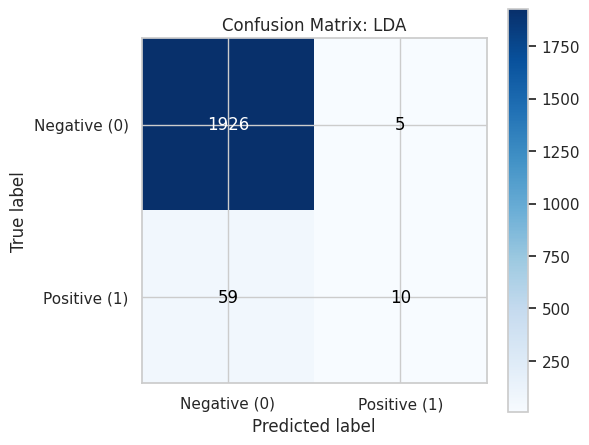

Sensitivity: 0.14
Specificity: 1.00
Precision: 0.67
F1 Score: 0.24
Accuracy: 0.97




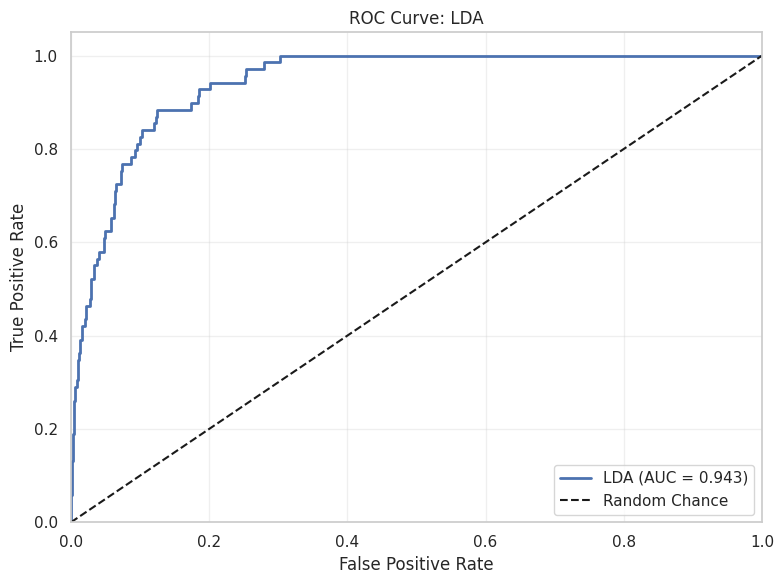

AUC: 0.94


LDA (Cleaned Data) Results
Confusion Matrix:


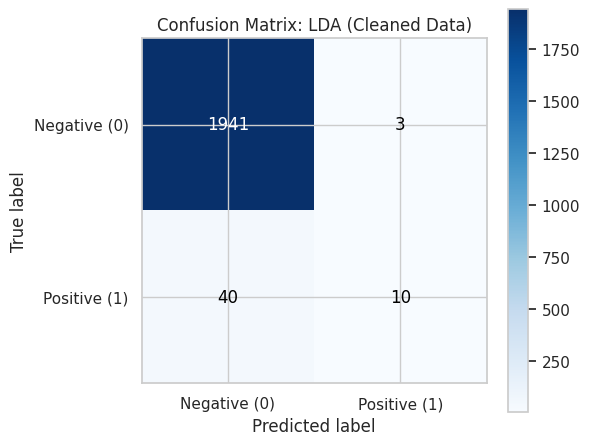

Sensitivity: 0.20
Specificity: 1.00
Precision: 0.77
F1 Score: 0.32
Accuracy: 0.98




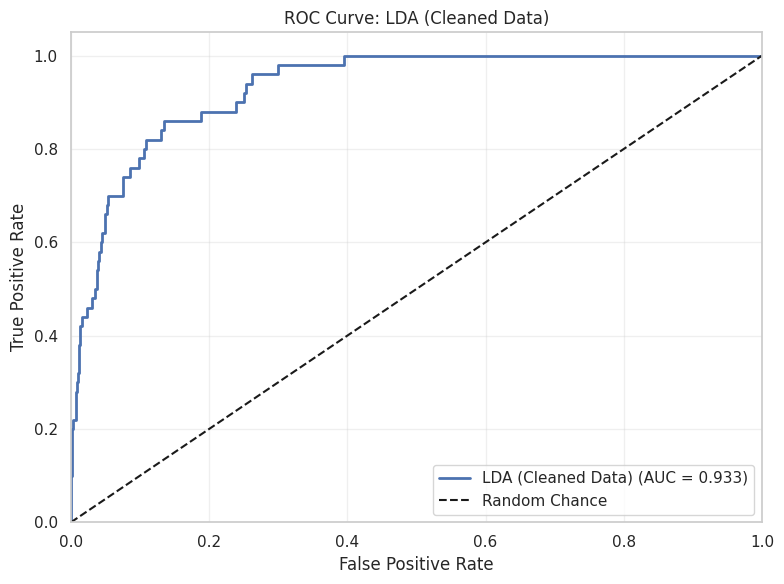

AUC: 0.93


LDA (Scaled Data) Results
Confusion Matrix:


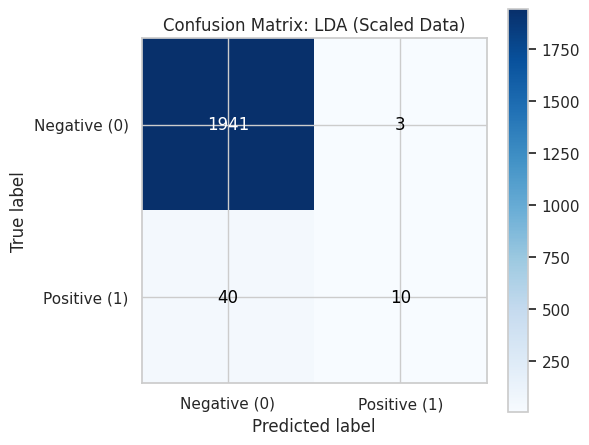

Sensitivity: 0.20
Specificity: 1.00
Precision: 0.77
F1 Score: 0.32
Accuracy: 0.98




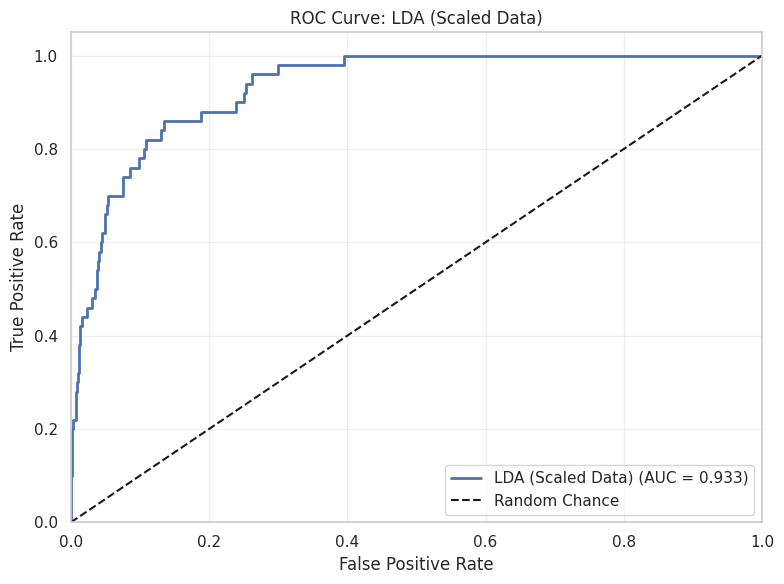

AUC: 0.93


LDA (Balanced Data) Results
Confusion Matrix:


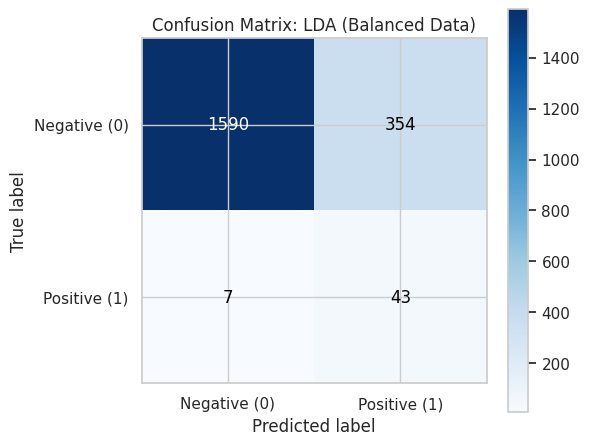

Sensitivity: 0.86
Specificity: 0.82
Precision: 0.11
F1 Score: 0.19
Accuracy: 0.82




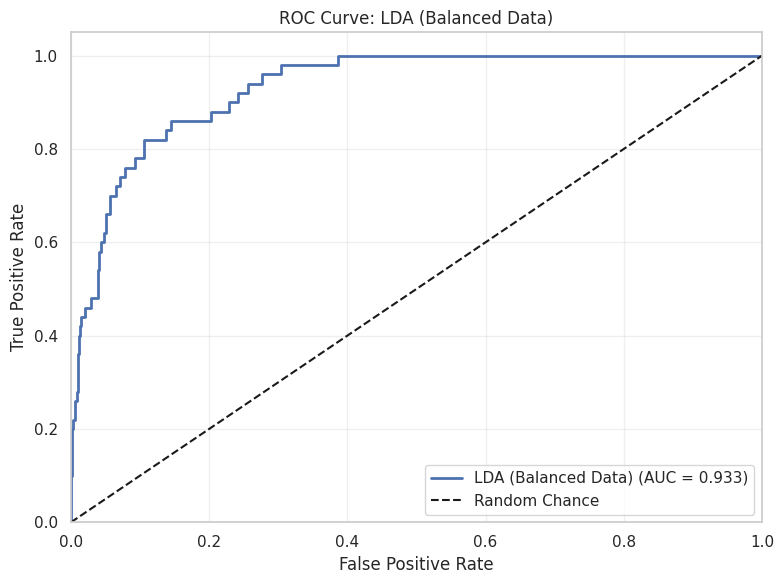

AUC: 0.93




In [24]:
# Plot and calculate metrics for LDA
if default_data_available:
    # Results for LDA
    print("LDA Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_lda = plot_confusion_matrix(y_test, y_pred_lda, model_name="LDA")
    sensitivity_lda, specificity_lda, precision_lda, f1_score_lda, accuracy_lda = result_metrics(cm_lda)
    print(f"Sensitivity: {sensitivity_lda:.2f}")
    print(f"Specificity: {specificity_lda:.2f}")
    print(f"Precision: {precision_lda:.2f}")
    print(f"F1 Score: {f1_score_lda:.2f}")
    print(f"Accuracy: {accuracy_lda:.2f}")
    print("\n")
    # Plot ROC curve for LDA
    auc_lda = plot_roc_curve(y_test, y_prob_lda, model_name="LDA")
    print(f"AUC: {auc_lda:.2f}")
    print("\n")

    # Results for LDA with cleaned data
    print("LDA (Cleaned Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_lda_cleaned = plot_confusion_matrix(y_test_cleaned, y_pred_lda_cleaned, model_name="LDA (Cleaned Data)")
    sensitivity_lda_cleaned, specificity_lda_cleaned, precision_lda_cleaned, f1_score_lda_cleaned, accuracy_lda_cleaned = result_metrics(cm_lda_cleaned)
    print(f"Sensitivity: {sensitivity_lda_cleaned:.2f}")
    print(f"Specificity: {specificity_lda_cleaned:.2f}")
    print(f"Precision: {precision_lda_cleaned:.2f}")
    print(f"F1 Score: {f1_score_lda_cleaned:.2f}")
    print(f"Accuracy: {accuracy_lda_cleaned:.2f}")
    print("\n")
    # Plot ROC curve for LDA with cleaned data
    auc_lda_cleaned = plot_roc_curve(y_test_cleaned, y_prob_lda_cleaned, model_name="LDA (Cleaned Data)")
    print(f"AUC: {auc_lda_cleaned:.2f}")
    print("\n")

    # Results for LDA with scaled data
    print("LDA (Scaled Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_lda_scaled = plot_confusion_matrix(y_test_scaled, y_pred_lda_scaled, model_name="LDA (Scaled Data)")
    sensitivity_lda_scaled, specificity_lda_scaled, precision_lda_scaled, f1_score_lda_scaled, accuracy_lda_scaled = result_metrics(cm_lda_scaled)
    print(f"Sensitivity: {sensitivity_lda_scaled:.2f}")
    print(f"Specificity: {specificity_lda_scaled:.2f}")
    print(f"Precision: {precision_lda_scaled:.2f}")
    print(f"F1 Score: {f1_score_lda_scaled:.2f}")
    print(f"Accuracy: {accuracy_lda_scaled:.2f}")
    print("\n")
    # Plot ROC curve for LDA with scaled data
    auc_lda_scaled = plot_roc_curve(y_test_scaled, y_prob_lda_scaled, model_name="LDA (Scaled Data)")
    print(f"AUC: {auc_lda_scaled:.2f}")
    print("\n")

    # Results for LDA with balanced data
    print("LDA (Balanced Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_lda_balanced = plot_confusion_matrix(y_test_scaled, y_pred_lda_balanced, model_name="LDA (Balanced Data)")
    sensitivity_lda_balanced, specificity_lda_balanced, precision_lda_balanced, f1_score_lda_balanced, accuracy_lda_balanced = result_metrics(cm_lda_balanced)
    print(f"Sensitivity: {sensitivity_lda_balanced:.2f}")
    print(f"Specificity: {specificity_lda_balanced:.2f}")
    print(f"Precision: {precision_lda_balanced:.2f}")
    print(f"F1 Score: {f1_score_lda_balanced:.2f}")
    print(f"Accuracy: {accuracy_lda_balanced:.2f}")
    print("\n")
    # Plot ROC curve for LDA with balanced data
    auc_lda_balanced = plot_roc_curve(y_test_scaled, y_prob_lda_balanced, model_name="LDA (Balanced Data)")
    print(f"AUC: {auc_lda_balanced:.2f}")
    print("\n")

### Naïve Bayes

In [25]:
# Fit the Naïve Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]

# Fit the Naïve Bayes model with cleaned data
nb_cleaned = GaussianNB()
nb_cleaned.fit(X_train_cleaned, y_train_cleaned)
y_pred_nb_cleaned = nb_cleaned.predict(X_test_cleaned)
y_prob_nb_cleaned = nb_cleaned.predict_proba(X_test_cleaned)[:, 1]

# Fit the Naïve Bayes model with scaled data
nb_scaled = GaussianNB()
nb_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_nb_scaled = nb_scaled.predict(X_test_scaled)
y_prob_nb_scaled = nb_scaled.predict_proba(X_test_scaled)[:, 1]

# Fit the Naïve Bayes model with balanced data
nb_balanced = GaussianNB()
nb_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_nb_balanced = nb_balanced.predict(X_test_scaled)
y_prob_nb_balanced = nb_balanced.predict_proba(X_test_scaled)[:, 1]


Naïve Bayes Results
Confusion Matrix:


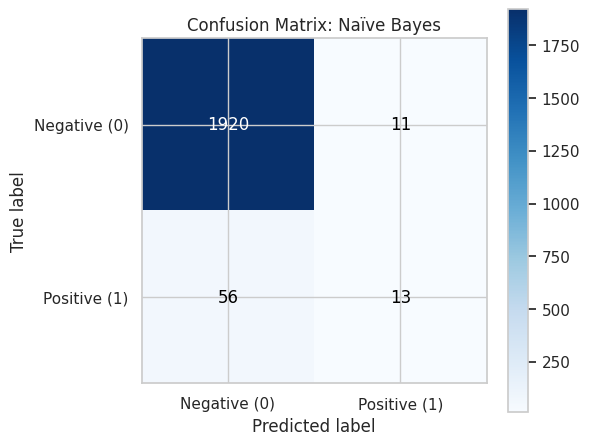

Sensitivity: 0.19
Specificity: 0.99
Precision: 0.54
F1 Score: 0.28
Accuracy: 0.97




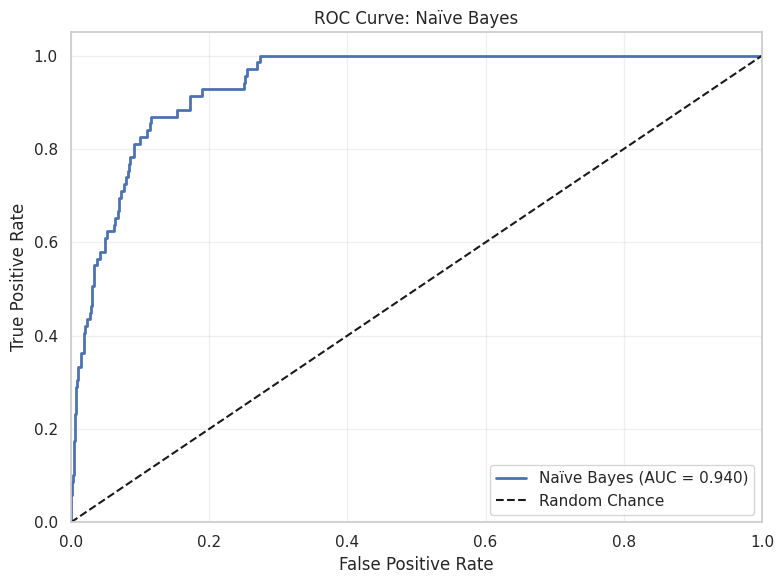

AUC: 0.94


Naïve Bayes (Cleaned Data) Results
Confusion Matrix:


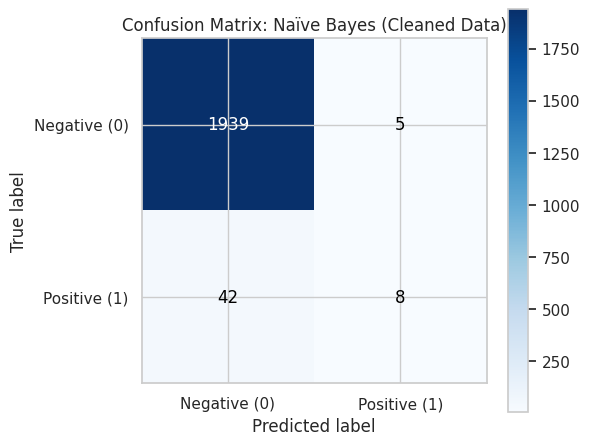

Sensitivity: 0.16
Specificity: 1.00
Precision: 0.62
F1 Score: 0.25
Accuracy: 0.98




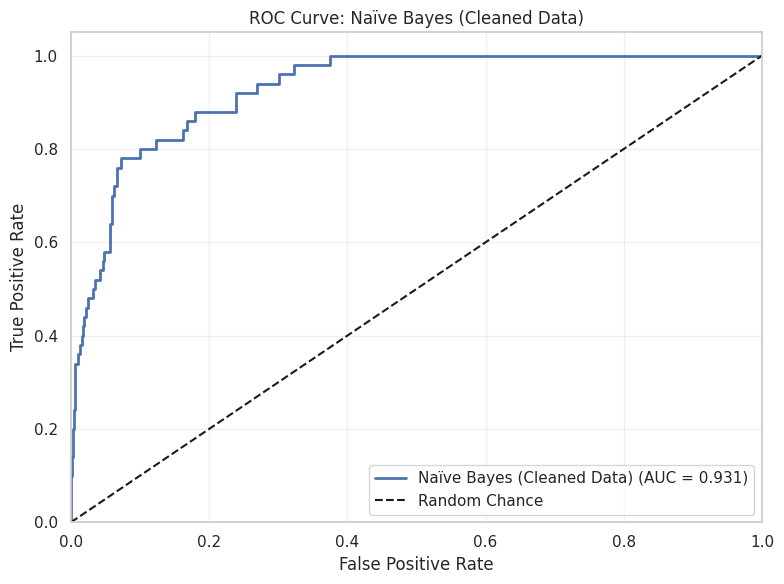

AUC: 0.93


Naïve Bayes (Scaled Data) Results
Confusion Matrix:


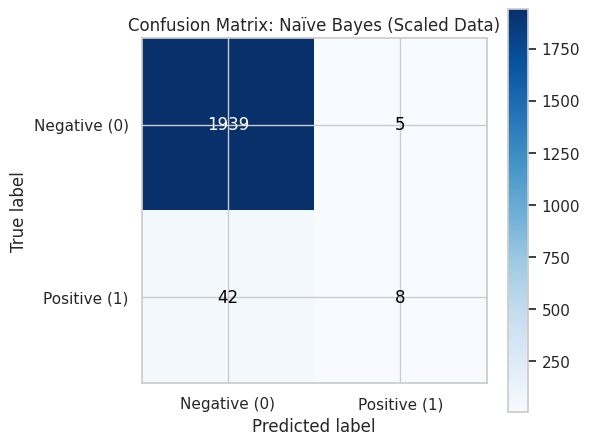

Sensitivity: 0.16
Specificity: 1.00
Precision: 0.62
F1 Score: 0.25
Accuracy: 0.98




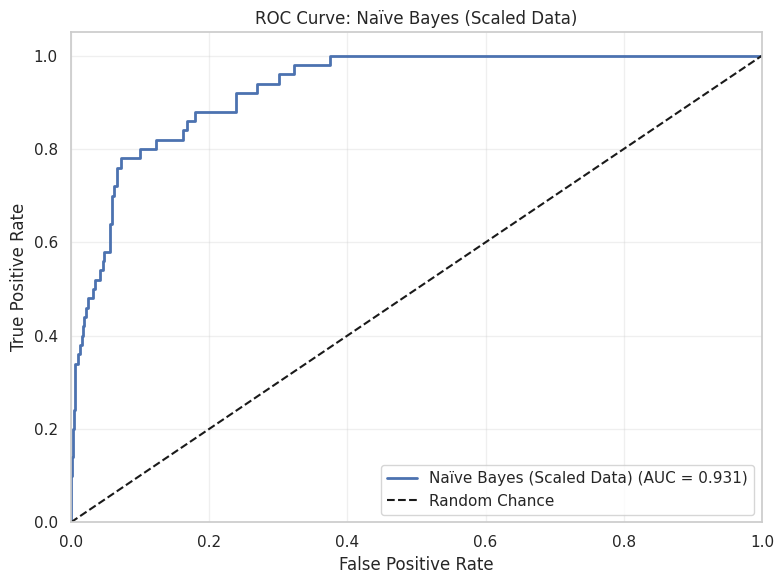

AUC: 0.93


Naïve Bayes (Balanced Data) Results
Confusion Matrix:


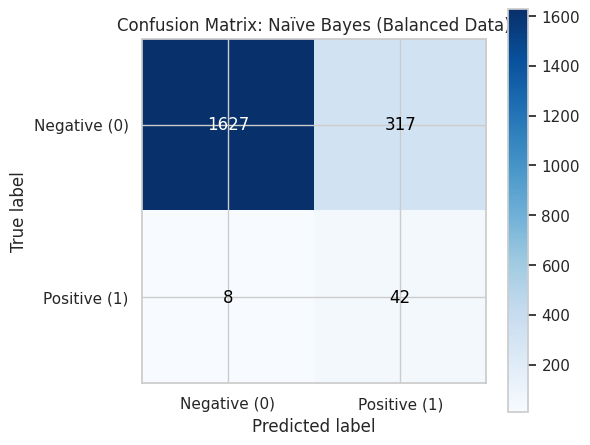

Sensitivity: 0.84
Specificity: 0.84
Precision: 0.12
F1 Score: 0.21
Accuracy: 0.84




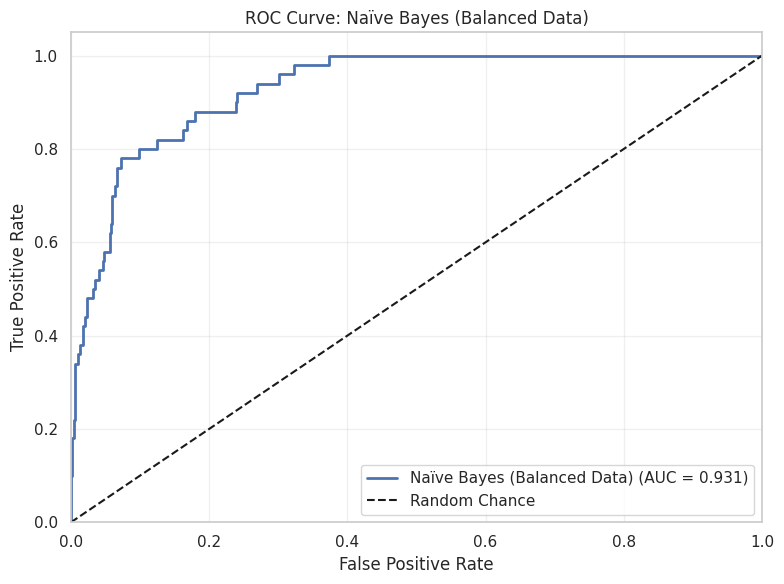

AUC: 0.93




In [26]:
# Plot and calculate metrics for Naïve Bayes
if default_data_available:
    # Results for Naïve Bayes
    print("Naïve Bayes Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_nb = plot_confusion_matrix(y_test, y_pred_nb, model_name="Naïve Bayes")
    sensitivity_nb, specificity_nb, precision_nb, f1_score_nb, accuracy_nb = result_metrics(cm_nb)
    print(f"Sensitivity: {sensitivity_nb:.2f}")
    print(f"Specificity: {specificity_nb:.2f}")
    print(f"Precision: {precision_nb:.2f}")
    print(f"F1 Score: {f1_score_nb:.2f}")
    print(f"Accuracy: {accuracy_nb:.2f}")
    print("\n")
    # Plot ROC curve for Naïve Bayes
    auc_nb = plot_roc_curve(y_test, y_prob_nb, model_name="Naïve Bayes")
    print(f"AUC: {auc_nb:.2f}")
    print("\n")

    
    # Results for Naïve Bayes with cleaned data
    print("Naïve Bayes (Cleaned Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_nb_cleaned = plot_confusion_matrix(y_test_cleaned, y_pred_nb_cleaned, model_name="Naïve Bayes (Cleaned Data)")
    sensitivity_nb_cleaned, specificity_nb_cleaned, precision_nb_cleaned, f1_score_nb_cleaned, accuracy_nb_cleaned = result_metrics(cm_nb_cleaned)
    print(f"Sensitivity: {sensitivity_nb_cleaned:.2f}")
    print(f"Specificity: {specificity_nb_cleaned:.2f}")
    print(f"Precision: {precision_nb_cleaned:.2f}")
    print(f"F1 Score: {f1_score_nb_cleaned:.2f}")
    print(f"Accuracy: {accuracy_nb_cleaned:.2f}")
    print("\n")
    # Plot ROC curve for Naïve Bayes with cleaned data
    auc_nb_cleaned = plot_roc_curve(y_test_cleaned, y_prob_nb_cleaned, model_name="Naïve Bayes (Cleaned Data)")
    print(f"AUC: {auc_nb_cleaned:.2f}")
    print("\n")

    # Results for Naïve Bayes with scaled data
    print("Naïve Bayes (Scaled Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_nb_scaled = plot_confusion_matrix(y_test_scaled, y_pred_nb_scaled, model_name="Naïve Bayes (Scaled Data)")
    sensitivity_nb_scaled, specificity_nb_scaled, precision_nb_scaled, f1_score_nb_scaled, accuracy_nb_scaled = result_metrics(cm_nb_scaled)
    print(f"Sensitivity: {sensitivity_nb_scaled:.2f}")
    print(f"Specificity: {specificity_nb_scaled:.2f}")
    print(f"Precision: {precision_nb_scaled:.2f}")
    print(f"F1 Score: {f1_score_nb_scaled:.2f}")
    print(f"Accuracy: {accuracy_nb_scaled:.2f}")
    print("\n")
    # Plot ROC curve for Naïve Bayes with scaled data
    auc_nb_scaled = plot_roc_curve(y_test_scaled, y_prob_nb_scaled, model_name="Naïve Bayes (Scaled Data)")
    print(f"AUC: {auc_nb_scaled:.2f}")
    print("\n")

    # Results for Naïve Bayes with balanced data
    print("Naïve Bayes (Balanced Data) Results")
    print("===================================")
    print("Confusion Matrix:")
    cm_nb_balanced = plot_confusion_matrix(y_test_scaled, y_pred_nb_balanced, model_name="Naïve Bayes (Balanced Data)")
    sensitivity_nb_balanced, specificity_nb_balanced, precision_nb_balanced, f1_score_nb_balanced, accuracy_nb_balanced = result_metrics(cm_nb_balanced)
    print(f"Sensitivity: {sensitivity_nb_balanced:.2f}")
    print(f"Specificity: {specificity_nb_balanced:.2f}")
    print(f"Precision: {precision_nb_balanced:.2f}")
    print(f"F1 Score: {f1_score_nb_balanced:.2f}")
    print(f"Accuracy: {accuracy_nb_balanced:.2f}")
    print("\n")
    # Plot ROC curve for Naïve Bayes with balanced data
    auc_nb_balanced = plot_roc_curve(y_test_scaled, y_prob_nb_balanced, model_name="Naïve Bayes (Balanced Data)")
    print(f"AUC: {auc_nb_balanced:.2f}")
    print("\n")